# Import part 

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

# Function part 

## Function to load and prepare data

In [2]:
def load_data(url):
    print("Loading dataset...")
    df = pd.read_csv(url)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

## Function to train and evaluate models

In [3]:
# Function to train and evaluate models
def train_and_evaluate_models(X, y):
    # Split data for initial evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print(f"Training set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")
    
    # Define configurations to test
    rf_configs = [
        {"n_estimators": 50, "max_depth": 3, "min_samples_split": 5, "max_features": "sqrt", "name": "RF-50-depth3"},
        {"n_estimators": 100, "max_depth": 4, "min_samples_split": 5, "max_features": "sqrt", "name": "RF-100-depth4"},
        {"n_estimators": 100, "max_depth": 5, "min_samples_split": 5, "max_features": "sqrt", "name": "RF-100-depth5"},
        {"n_estimators": 200, "max_depth": 3, "min_samples_split": 10, "max_features": "sqrt", "name": "RF-200-depth3-mss10"}
    ]
    
    best_model = None
    best_score = 0
    best_config = None
    
    # Test each configuration
    for config in rf_configs:
        print(f"\nTesting configuration: {config['name']}")
        
        rf = RandomForestClassifier(
            n_estimators=config["n_estimators"],
            max_depth=config["max_depth"],
            min_samples_split=config["min_samples_split"],
            max_features=config["max_features"],
            random_state=42
        )
        
        # Perform cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(rf, X, y, cv=cv)
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        print(f"Cross-validation accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
        
        # Train on full training set and evaluate on test set
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f"Test accuracy: {test_accuracy:.4f}")
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)
        
        # Calculate precision, recall, and F1 score
        report = classification_report(y_test, y_pred, output_dict=True)
        print("Classification Report:")
        print(f"Precision: {report['1']['precision']:.4f}")
        print(f"Recall: {report['1']['recall']:.4f}")
        print(f"F1 Score: {report['1']['f1-score']:.4f}")
        
        # Check if this is the best model so far
        if cv_mean > best_score:
            best_score = cv_mean
            best_config = config
            best_model = rf
    
    return best_model, best_config, best_score

## Function to save the model

In [5]:
def save_model(model, feature_names, config, accuracy, feature_importance):
    # Save with pickle for Python applications
    with open('heart_disease_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    # Save metadata and model configuration as JSON for reference
    model_data = {
        "config": config,
        "featureNames": feature_names,
        "accuracy": float(accuracy),
        "featureImportance": feature_importance,
        "timestamp": pd.Timestamp.now().isoformat()
    }
    
    with open('heart_disease_model_metadata.json', 'w') as f:
        json.dump(model_data, f, indent=2)
    
    print("\nModel saved to heart_disease_model.pkl")
    print("Model metadata saved to heart_disease_model_metadata.json")

# run part 

In [6]:
# Load data
url = "cleaned_data.csv"
data = load_data(url)

Loading dataset...
Dataset loaded: 920 rows, 24 columns


In [8]:
# Basic data exploration
print("\nFirst few rows:")
print(data.head().T)
print("\nColumn names:", data.columns.tolist())


First few rows:
                                 0         1         2         3         4
age                       1.007386  1.432034  1.432034 -1.752828 -1.328180
trestbps                  0.715785  1.545575 -0.667200 -0.114006 -0.114006
chol                      0.199127  0.906503  0.145740  0.426021 -0.187928
fbs                       1.000000  0.000000  0.000000  0.000000  0.000000
thalch                    0.489727 -1.181478 -0.345875  1.961979  1.365120
exang                     0.000000  1.000000  1.000000  0.000000  0.000000
oldpeak                   1.396276  0.617806  1.688203  2.563983  0.520497
num                       0.000000  0.500000  0.250000  0.000000  0.000000
ca                        0.000000  1.000000  0.666667  0.000000  0.000000
sex_Female                0.000000  0.000000  0.000000  0.000000  1.000000
sex_Male                  1.000000  1.000000  1.000000  1.000000  0.000000
cp_asymptomatic           0.000000  1.000000  1.000000  0.000000  0.000000
cp_atypi

In [15]:
# Extract features and target
X = data.drop('num', axis=1)
y = (data['num'] >= 0.2).astype(int)

In [16]:
# Count classes
class_counts = y.value_counts()
print("\nClass distribution:")
print(class_counts)


Class distribution:
num
1    509
0    411
Name: count, dtype: int64


In [17]:
# Train and evaluate models
best_model, best_config, best_score = train_and_evaluate_models(X, y)

print("\n=== Best Model ===")
print(f"Configuration: {best_config['name']}")
print(f"Cross-validation accuracy: {best_score:.4f}")

Training set: 644 samples, Test set: 276 samples

Testing configuration: RF-50-depth3
Cross-validation accuracy: 0.8478 ± 0.0124
Test accuracy: 0.8551
Confusion Matrix:
[[ 97  23]
 [ 17 139]]
Classification Report:
Precision: 0.8580
Recall: 0.8910
F1 Score: 0.8742

Testing configuration: RF-100-depth4
Cross-validation accuracy: 0.8522 ± 0.0126
Test accuracy: 0.8623
Confusion Matrix:
[[ 99  21]
 [ 17 139]]
Classification Report:
Precision: 0.8688
Recall: 0.8910
F1 Score: 0.8797

Testing configuration: RF-100-depth5
Cross-validation accuracy: 0.8522 ± 0.0193
Test accuracy: 0.8696
Confusion Matrix:
[[100  20]
 [ 16 140]]
Classification Report:
Precision: 0.8750
Recall: 0.8974
F1 Score: 0.8861

Testing configuration: RF-200-depth3-mss10
Cross-validation accuracy: 0.8446 ± 0.0167
Test accuracy: 0.8732
Confusion Matrix:
[[ 98  22]
 [ 13 143]]
Classification Report:
Precision: 0.8667
Recall: 0.9167
F1 Score: 0.8910

=== Best Model ===
Configuration: RF-100-depth4
Cross-validation accuracy: 0.

In [18]:
# Train best model on full dataset
best_model = RandomForestClassifier(
    n_estimators=best_config["n_estimators"],
    max_depth=best_config["max_depth"],
    min_samples_split=best_config["min_samples_split"],
    max_features=best_config["max_features"],
    random_state=42
)

best_model.fit(X, y)

RandomForestClassifier(max_depth=4, min_samples_split=5, random_state=42)

In [19]:
# Get feature importance
feature_importance = best_model.feature_importances_
feature_names = X.columns.tolist()

In [20]:
# Create sorted feature importance list
importance_array = [{"feature": name, "importance": float(importance)} 
                    for name, importance in zip(feature_names, feature_importance)]
importance_array.sort(key=lambda x: x["importance"], reverse=True)

print("\nFeature Importance:")
for item in importance_array[:10]:  # Show top 10
    print(f"{item['feature']}: {item['importance']:.4f}")


Feature Importance:
thal_normal: 0.1690
cp_asymptomatic: 0.1687
slope_upsloping: 0.1279
ca: 0.0757
exang: 0.0724
chol: 0.0570
oldpeak: 0.0477
thalch: 0.0456
slope_flat: 0.0418
cp_atypical angina: 0.0406


In [ ]:
# Save the model
save_model(best_model, feature_names, best_config, best_score, importance_array)a

Feature importance plot saved to feature_importance.png


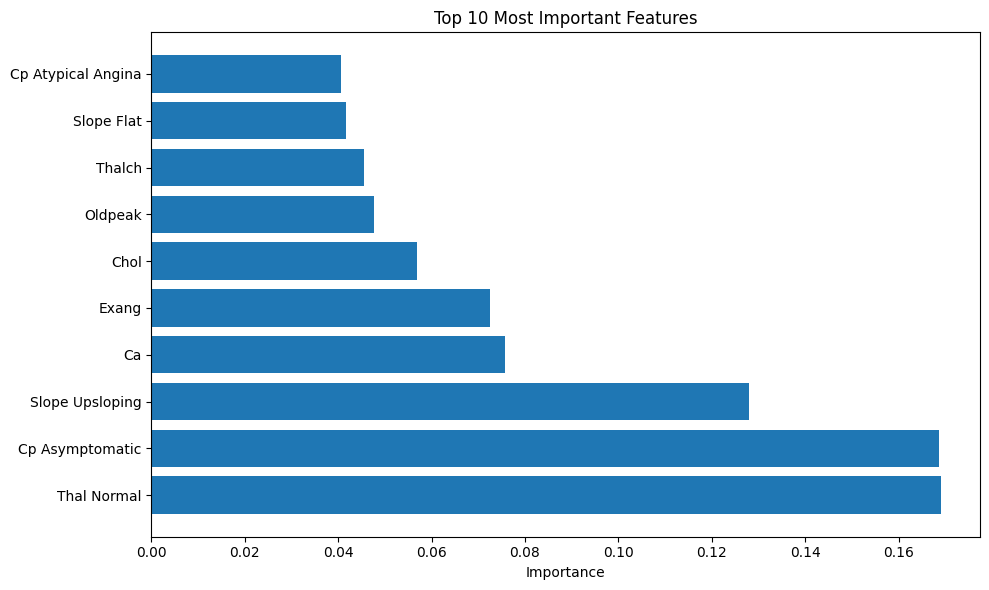

In [21]:
# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = importance_array[:10]
feature_names_display = [item["feature"].replace("_", " ").title() for item in top_features]
importance_values = [item["importance"] for item in top_features]

plt.barh(feature_names_display, importance_values)
plt.xlabel("Importance")
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.savefig("feature_importance.png")
print("Feature importance plot saved to feature_importance.png")